# Simulations numériques de l'étude d'impact

Références : 
* *Projet de loi instituant un système universel de retraite.* - Etude d'impact, 24 janvier 2020
* *Évolutions et perspectives des retraites en France.* Rapport annuel du COR – Juin 2019

In [1]:
from SimulateurRetraites import SimulateurRetraites
from SimulateurAnalyse import SimulateurAnalyse
import pylab as pl
from scipy import interpolate

## Analyse de l'étude d'impact : dépenses de retraites

Le rapport du COR de Juin 2019 présente les dépenses de retraites jusqu'en 2070. 

![Dépenses constatées et projetées du système de retraite actuel](COR-Depenses-vs-PIB-Juin-2019.png "Dépenses de retraite (COR, Juin 2019)")

Le rapport du COR de Novembre 2019 présente les dépenses de retraites jusqu'à 2030, compte tenu des mesures de restriction des ressources exigées par le gouvernement. 

![Dépenses constatées et projetées du système de retraite actuel](COR-Novembre-2019-Depenses.png "Dépenses de retraite (COR, Novembre 2019)")


L'étude d'impact, page 174, présente une analyse du niveau de dépenses en % de PIB : "Ce taux est plus élevé que ce qu’on observe dans les autres pays européens. Les prestations de vieillesse-survie (correspondant au champ comparable internationalement, plus large que les dépenses du seul système de retraite) représentent 14,4 % du PIB en France, contre 12,6 % du PIB dans l’UE-15 et 12,3 % dans l’UE-28."

Dans l'étude d'impact, page 174, le graphique 58 présente les dépenses constatées et projetées du système de retraite actuel, en points de PIB. 

![Dépenses constatées et projetées du système de retraite actuel](EtudeImpact-depenses-constatees-projetees.png "Dépenses constatées et projetées du système de retraite actuel (Etude d'impact, Janvier 2020")

Analysons cette trajectoire de dépenses par comparaison avec celles du COR.
* Ces dépenses correspondent à celle du COR de Novembre 2019, comme c'est précisé dans l'étude d'impact. 
* Cette trajectoire ne correspond pas à la trajectoire à 1.3% dans le rapport du COR de Juin 2019. En effet, l'étude d'impact évoque la trajectoire de dépenses du rapport du COR de Novembre 2019 (et pas Juin 2019) à +1.3% de hausse des salaires et un taux de chômage de 7%. Or ce scénario mène à un niveau de dépenses de 13.5% en 2050 dans le rapport du COR de Juin 2019, alors que l'étude d'impact est proche de 13%.
* Ces dépenses correspondent approximativement à la trajectoire à +1.5% du rapport de Juin 2019 jusqu'à 2050. 

## Analyse de l'étude d'impact : situation financière

La figure suivante présente le solde financier du système de retraite extrait du rapport du COR en Juin 2019.

![Solde du système de retraite (Convention COR)](COR-Solde-Financier-Juin-2019.png "Solde du système de retraite (COR, Juin 2019")

L'étude d'impact, page 180, présente une analyse du solde financier du système de retraite avant et après réforme. 

![Solde du système de retraite, avant et après réforme](EtudeImpact-situation-financiere.png "Solde du système de retraite, avant et après réforme (Etude d'impact, Janvier 2020")

Le texte indique : "Compte tenu des hypothèses décrites plus haut et en y ajoutant une mesure conventionnelle de
redressement à court terme afin d’être à l’équilibre en 2027, le graphique ci-après présente la trajectoire du solde du SUR en la comparant à la trajectoire contrefactuelle (hors réforme) à l’horizon 2050."

C'est pourquoi nous devons considérer un solde financier :
* inchangé avant 2020,
* linéairement croissant de -0.2 en 2020 jusqu'à 0 en 2027,
* puis nul ensuite.

## Hypothèses : conjoncture

Nous considérons ici les hypothèses du COR de Juin 2019.

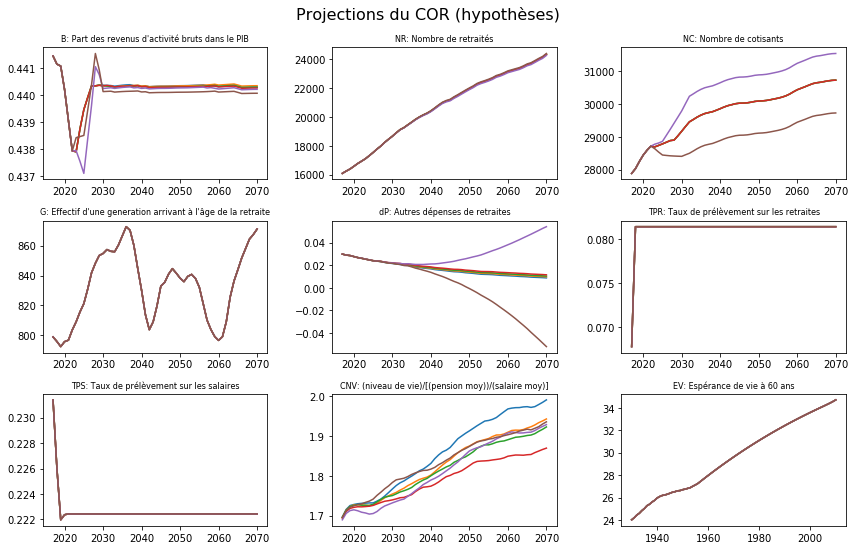

In [2]:
simulateur = SimulateurRetraites('../retraites/fileProjection.json')

analyse = simulateur.pilotageCOR()

pl.figure(figsize=(12,8))
pl.suptitle(u"Projections du COR (hypothèses)",fontsize=16)
for c in range(9):
    pl.subplot(3,3,c+1)
    v,V = [ (simulateur.B,'B'), (simulateur.NR,'NR'), (simulateur.NC,'NC'), \
            (simulateur.G,'G'), (simulateur.dP,'dP'), (simulateur.TCR,'TPR'), 
            (simulateur.TCS,'TPS'), (simulateur.CNV,'CNV'), (simulateur.EV,'EV') ][c]
    analyse.graphique(v,V)
pl.tight_layout(rect=[0, 0.03, 1, 0.95])    

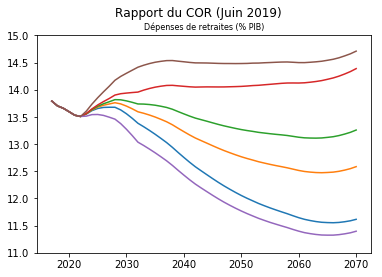

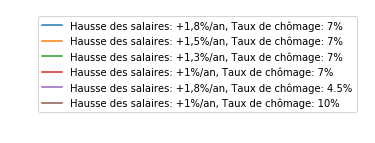

In [3]:
pl.suptitle("Rapport du COR (Juin 2019)");
analyse.graphique(analyse.Depenses,"Depenses")
analyse.plot_legend()

## Calcul de la trajectoire de dépenses

Pour cette trajectoire de dépenses, nous considérons les mêmes niveaux de dépenses de les dépenses de l'étude d'impact de 2020 à 2050. Pour la période 2050-2070, nous faisons l'hypothèse que le niveau de dépense s'abaisse jusqu'à la moyenne 12,6 % du PIB dans l’UE-15. 

Nous commençons par extraire les dépenses constatées jusqu'à 2020 dans les données du COR.

In [4]:
analyse = simulateur.pilotageCOR()

In [5]:
annees_constatees = []
depenses_constatees = []
s = 1 # Premier scénario
for a in simulateur.annees:
    if (a<2021):
        annees_constatees.append(a)
        depenses_constatees.append(analyse.Depenses[s][a])

In [6]:
premiere_annee_constatee = annees_constatees[0]
premiere_annee_constatee

2017

In [7]:
derniere_depense_constatee = depenses_constatees[-1]
derniere_depense_constatee

0.13595867407644283

Puis nous lisons les données sur la figure 58 de l'étude d'impact, en extrapolant jusqu'à 2070.

In [8]:
annees = [2020, 2025, 2030, 2040, 2050, 2060, 2070]
depenses = [derniere_depense_constatee, 0.138, 0.138, 0.136, 0.130, 0.127, 0.126]
nb_annees = len(annees)

Pour compléter les données entre deux dates imposées, nous utilisons l'interpolateur du module scipy, fondé sur une spline quadratique.

In [9]:
depenses_interpolateur = interpolate.interp1d(annees, depenses, kind="quadratic")

Nous séparons la période en deux. La première est la période de l'étude d'impact tandis que la second est celle de l'extrapolation.

In [10]:
annees_table_EI = range(2020,2051)
depenses_table_EI = depenses_interpolateur(annees_table_EI)

In [11]:
annees_table_extrapolation = range(2050,2071)
depenses_table_extrapolation = depenses_interpolateur(annees_table_extrapolation)

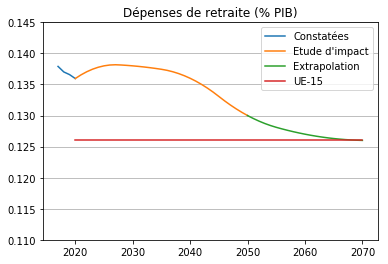

In [12]:
pl.plot(annees_constatees, depenses_constatees, label="Constatées")
pl.plot(annees_table_EI, depenses_table_EI, label="Etude d'impact")
pl.plot(annees_table_extrapolation, depenses_table_extrapolation, label="Extrapolation")
pl.ylim(bottom=0.11, top=0.145)
pl.title("Dépenses de retraite (% PIB)");
pl.plot(annees,[0.126]*nb_annees, label="UE-15")
pl.legend();
pl.grid(axis="y")

Sur cette base, nous créeons le scénario de la simulation à partir de cette trajectoire. 
* Pour le début de la trajectoire, nous utilisons les données du COR.
* Le reste, nous utilisons les dépenses de l'étude d'impact.

In [13]:
depenses_EI = analyse.Depenses
for s in simulateur.scenarios:
    for a in simulateur.annees_futures:
        if (a>=2020):
            depenses_EI[s][a] = depenses_interpolateur(a)

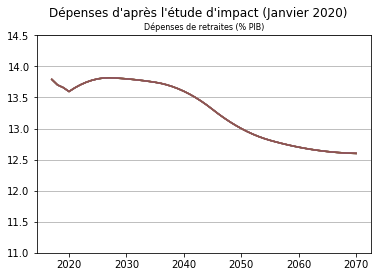

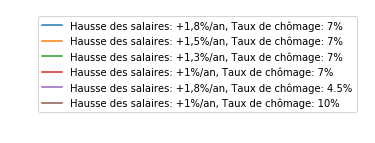

In [14]:
pl.suptitle("Dépenses d'après l'étude d'impact (Janvier 2020)");
analyse.graphique(depenses_EI,"Depenses")
pl.grid(axis="y")
pl.ylim(bottom=11.0, top=14.5)
analyse.plot_legend()

## Calcul de la trajectoire de solde financier

Nous commençons par extraire les soldes constatés jusqu'à 2020 dans les données du COR.

In [15]:
analyse = simulateur.pilotageCOR()

In [16]:
soldes_constatees = []
s = 1 # Premier scénario
for a in simulateur.annees:
    if (a<2021):
        soldes_constatees.append(analyse.S[s][a])

In [17]:
dernier_solde_constate = soldes_constatees[-1]
dernier_solde_constate

-0.0004594256008767406

Puis nous lisons les données sur la figure 63 de l'étude d'impact, en extrapolant jusqu'à 2070.

In [18]:
annees = [2020, 2027, 2070]
soldes = [dernier_solde_constate, 0.0, 0.0]

Pour compléter les données entre deux dates imposées, nous utilisons l'interpolateur du module scipy, fondé sur un interpolateur linéaire par morceaux.

In [19]:
soldes_interpolateur = interpolate.interp1d(annees, soldes)

In [20]:
annees_table_EI = range(2020,2071)
soldes_table_EI = soldes_interpolateur(annees_table_EI)

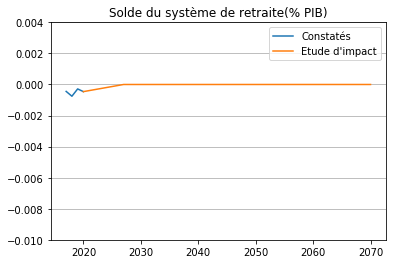

In [21]:
pl.plot(annees_constatees, soldes_constatees, label="Constatés")
pl.plot(annees_table_EI, soldes_table_EI, label="Etude d'impact")
pl.ylim(bottom=-0.010, top=0.004)
pl.title("Solde du système de retraite(% PIB)");
pl.legend();
pl.grid(axis="y")

Sur cette base, nous créeons le scénario de la simulation à partir de cette trajectoire. 
* Pour le début de la trajectoire, nous utilisons les données du COR.
* Le reste, nous utilisons le solde financier de l'étude d'impact.

In [22]:
soldes_EI = analyse.S
for s in simulateur.scenarios:
    for a in simulateur.annees_futures:
        if (a>=2020):
            soldes_EI[s][a] = soldes_interpolateur(a)

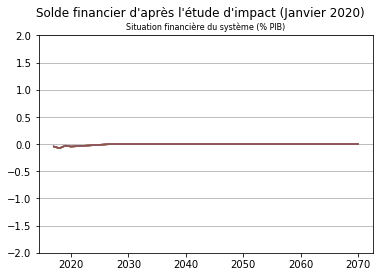

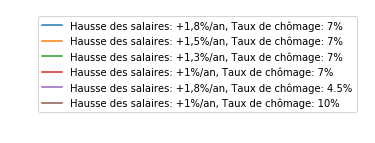

In [23]:
pl.suptitle("Solde financier d'après l'étude d'impact (Janvier 2020)");
analyse.graphique(soldes_EI,"S")
pl.grid(axis="y")
analyse.plot_legend()

## Simulation de l'étude d'impact

Cette stratégie de pilotage est celle dans laquelle :
* le bilan financier est celui de l'étude d'impact (Janvier 2020),
* l'âge de départ à la retraite est celui du COR (Juin 2019),
* le montant des dépenses est celui de l'étude d'impact (Janvier 2020).

In [24]:
analyse = simulateur.pilotageParAgeEtDepenses(Dcible=depenses_EI, Scible=soldes_EI)

Utilise l'âge du COR


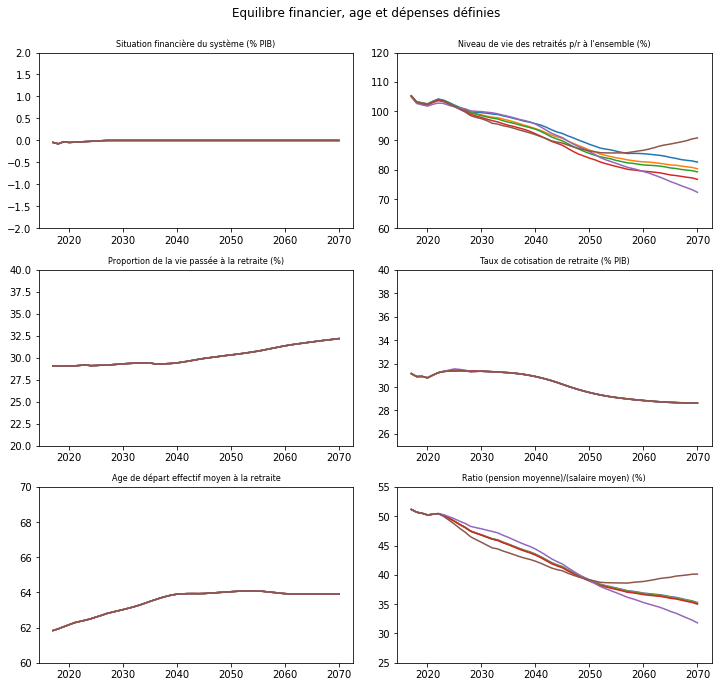

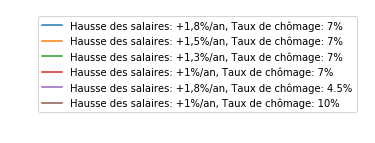

In [25]:
pl.figure(figsize=(10,10))
pl.suptitle(u"Equilibre financier, age et dépenses définies")
analyse.graphiques()
analyse.plot_legend()

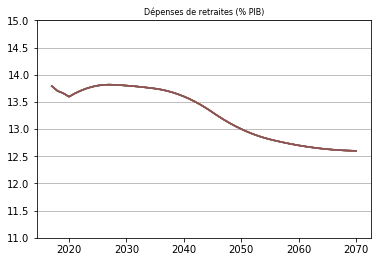

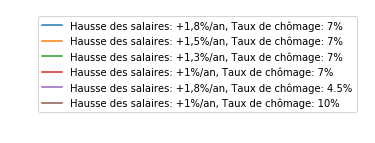

In [26]:
analyse.graphique(analyse.Depenses,"Depenses")
pl.grid(axis="y")
analyse.plot_legend()

On constate que l'on ne reproduit pas les dépenses indiquées dans l'étude d'impact, mais qu'on reproduit correctement les dépenses du rapport du COR de Juin 2019.

In [27]:
analyse.affiche_solutions_simulateur_COR()

Valeurs à rentrer sur le simulateur officiel du COR:

Scenario 1 :  Hausse des salaires: +1,8%/an, Taux de chômage: 7%
Annéee, Age,      Cotis., Pension:
 2020 : 62.2 ans, 30.8 %, 50.2 %
 2025 : 62.6 ans, 31.4 %, 49.1 %
 2030 : 63.0 ans, 31.3 %, 46.8 %
 2040 : 63.9 ans, 30.9 %, 43.5 %
 2050 : 64.0 ans, 29.5 %, 39.2 %
 2060 : 63.9 ans, 28.8 %, 36.9 %
 2070 : 63.9 ans, 28.6 %, 35.3 %

Scenario 2 :  Hausse des salaires: +1,5%/an, Taux de chômage: 7%
Annéee, Age,      Cotis., Pension:
 2020 : 62.2 ans, 30.8 %, 50.2 %
 2025 : 62.6 ans, 31.4 %, 49.1 %
 2030 : 63.0 ans, 31.3 %, 46.8 %
 2040 : 63.9 ans, 30.9 %, 43.5 %
 2050 : 64.0 ans, 29.5 %, 39.1 %
 2060 : 63.9 ans, 28.8 %, 36.8 %
 2070 : 63.9 ans, 28.6 %, 35.2 %

Scenario 3 :  Hausse des salaires: +1,3%/an, Taux de chômage: 7%
Annéee, Age,      Cotis., Pension:
 2020 : 62.2 ans, 30.8 %, 50.2 %
 2025 : 62.6 ans, 31.4 %, 49.1 %
 2030 : 63.0 ans, 31.3 %, 46.8 %
 2040 : 63.9 ans, 30.9 %, 43.4 %
 2050 : 64.0 ans, 29.5 %, 39.0 %
 2060 : 63.9 ans,